In [144]:
# Script to read timings.json files from different run setups and plot them

import json
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import pandas as pd
import seaborn as sns

def round_to_significant_digits(number, significant_digits=3):
    if pd.isnull(number) or not isinstance(number, (int, float)):
        return number
    if number == 0:
        return 0
    else:
        return round(number, significant_digits - int(np.floor(np.log10(abs(number)))) - 1)


# Build the path to the pdb files
file_dir = os.getcwd()
folder_name = file_dir.split('/')[-1]
repo_dir = file_dir.replace(f'/{folder_name}', '')
plot_dir = f'{file_dir}/plots'
os.makedirs(plot_dir, exist_ok=True)
json_dir = f"{repo_dir}/tournament_benchmark/"

sys.path.append(repo_dir)
from colors import COLOR

setups = ["one_to_one", "one_to_two", "one_to_four", "one_to_eight", "one_to_ten"]

# Read the timings.json files
timings = {}

# Helper function to calculate total run time from timings.json
def get_total_time(timings):
    total_time = 0
    for key in timings:
        total_time += timings[key]
    return total_time

results = []
for setup in setups:
    # List subfolders in the setup folder
    setup_folder = f"{json_dir}/{setup}"
    subfolders = [f.path for f in os.scandir(setup_folder) if f.is_dir()]

    # Calculate runtime for each subfolder
    for subfolder in subfolders:
        receptor = subfolder.split("/")[-1].split("_")[0]
        with open(f"{subfolder}/timings.json", "r") as f:
            timings[subfolder] = json.load(f)

        with open(f"{subfolder}/msas/chain_id_map.json", "r") as f:
            chains = json.load(f)
            ligands = []
            for chain in chains:
                if "_" in chains[chain]["description"]:
                    continue
                else:
                    ligands.append(chains[chain]["description"])

        results.append([setup, receptor, ligands, get_total_time(timings[subfolder]), True])

# Create a pandas dataframe
df = pd.DataFrame(results, columns=["Setup", "Receptor", "Ligands", "Time", "Tournament"])

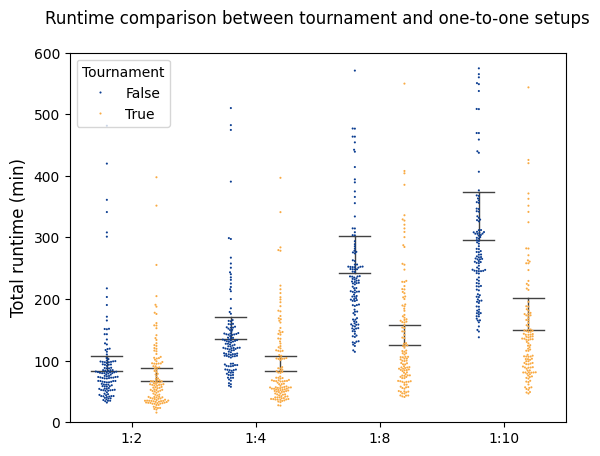

In [145]:
results_baseline = []
for index, row in df.iterrows():
    
    baseline_time = 0
    for ligand in row["Ligands"]:
        baseline_model = f"{json_dir}/baseline/{row['Receptor']}_human___{ligand}/timings.json"
        with open(baseline_model, "r") as f:
            baseline_time += get_total_time(json.load(f))

    results_baseline.append([row["Setup"], row["Receptor"], row["Ligands"], baseline_time, False])

df_baseline = pd.DataFrame(results_baseline, columns=["Setup", "Receptor", "Ligands", "Time", "Tournament"])
df_merged = pd.concat([df, df_baseline])

# Replace the setup names with more descriptive names
df_merged["Setup"] = df_merged["Setup"].replace({
    "one_to_one": "1:1",
    "one_to_two": "1:2",
    "one_to_four": "1:4",
    "one_to_eight": "1:8",
    "one_to_ten": "1:10"
})

# Drop one_to_one setup
df_merged = df_merged[df_merged["Setup"] != "1:1"]

# Make time into minutes
df_merged["Time_min"] = df_merged["Time"] / 60

# Calculate the means and standard deviations for error bars by setup and tournament
grouped_stats = df_merged.groupby(["Setup", "Tournament"])["Time_min"].agg(["mean", "std"]).reset_index()

# Make a swarm plot to show the timings for each setup
fig, ax = plt.subplots()
ax = sns.swarmplot(
    data=df_merged,
    x="Setup",
    y="Time_min",
    hue="Tournament",
    dodge=True,
    ax=ax,
    size=1.5,
    palette=["#0b3d91", "#f9aa43"]
)

sns.barplot(
    x="Setup",
    y="Time_min",
    hue="Tournament",
    data=df_merged,
    capsize=0.5,
    alpha=0.0,
    ax=ax,
    err_kws={'linewidth': 1.0},
    legend=False
)

# Make sure svg fonts
plt.rcParams['svg.fonttype'] = 'none'
plt.ylim(0, 600)
plt.title("Runtime comparison between tournament and one-to-one setups\n")
plt.xlabel("")

# Increase axis labels
plt.ylabel("Total runtime (min)", fontsize="large")
plt.savefig(f"{plot_dir}/timings.svg", format="svg")
plt.show()

In [147]:
# Use paired Wilcoxon signed-rank test to compare the tournament and baseline timings
from scipy.stats import wilcoxon

wilcoxon_results = []
for setup in df_merged["Setup"].unique():
    if setup == "one_to_one":
        continue
    df_merged = df_merged.sort_values(by=["Receptor"])
    tournament_times = df_merged[(df_merged["Setup"] == setup) & (df_merged["Tournament"] == True)]["Time"]
    baseline_times = df_merged[(df_merged["Setup"] == setup) & (df_merged["Tournament"] == False)]["Time"]
    stat, p_val = wilcoxon(tournament_times, baseline_times)
    wilcoxon_results.append([setup, tournament_times.mean(), baseline_times.mean(), stat, p_val])

df_wilcoxon = pd.DataFrame(wilcoxon_results, columns=["Setup", "Tournament time (s)", "Baseline time (s)", "Statistic", "p-value"])

# Apply function to all numeric columns in the DataFrame
for col in df_wilcoxon.columns:
    df_wilcoxon[col] = df_wilcoxon[col].apply(lambda x: round_to_significant_digits(x, 6) if pd.to_numeric(x, errors='coerce') is not None else x)

df_wilcoxon.to_csv(f"{json_dir}/tournament_runtime_wilcoxon.csv", index=False)
df_wilcoxon

,Setup,Tournament time (s),Baseline time (s),Statistic,p-value
0,1:2,4619.38,5671.08,2618.0,1.721170e-03
1,1:10,10438.80,19861.10,479.0,2.485200e-17
2,1:4,5692.62,9075.28,1281.0,9.891730e-11
3,1:8,8438.86,16166.80,628.0,5.634620e-16
